In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
fmm_fft_df_raw = pd.read_csv('data_fmmfft.txt', names = ['N', 'p', 'b', 't', 'time', 'err']).drop(columns=['b','t', 'err'])
fftw_mpi_df_raw = pd.read_csv('out_fftw_mpi.txt', usecols=[0,1,2,3],names = ['N', 'p', 'run_num','time']).drop(columns='run_num')

NameError: name 'pd' is not defined

In [79]:
serial_df = serial_df_raw.groupby(['N'], as_index=False).max()
fftw_mpi_df = fftw_mpi_df_raw.groupby(['N', 'p'], as_index=False).median()
fmm_fft_df = fmm_fft_df_raw.groupby(['N', 'p'], as_index=False).median()

## Speedup w.r.t Serial

In [80]:
problem_sizes = sorted(list(set(serial_df['N'].unique().tolist()) & set(fmm_fft_df['N'].unique().tolist())))
cores = sorted(fmm_fft_df['p'].unique().tolist())

speedup_serial_df_matrix = []

for n in problem_sizes:
    row_insert = [n]
    for p in cores:
        #print(n,p)
        fmm_fft_rows = fmm_fft_df.loc[(fmm_fft_df['N']==n) & (fmm_fft_df['p']==p)]
        serial_rows = serial_df.loc[(serial_df['N']==n)]
        if fmm_fft_rows.shape[0] == 0 or serial_rows.shape[0]==0: 
            row_insert.append(0)
            continue 
        fmm_fft_time = fmm_fft_rows.iloc[0]['time']
        serial_time = serial_rows.iloc[0]['time']
        speedup = serial_time/fmm_fft_time
        row_insert.append(speedup)
    speedup_serial_df_matrix.append(row_insert)

speedup_serial_df = pd.DataFrame(speedup_serial_df_matrix, columns=['N'] + [str(c) for c in cores])
speedup_serial_df

,N,2,4,8,16,32,64
0,32768,0.232944,0.193110,0.155239,0.042875,0.004831,0.000000
1,65536,0.272386,0.237199,0.239524,0.009016,0.009280,0.000000
2,131072,0.276865,0.261650,0.340342,0.009656,0.018392,0.007567
3,262144,0.580823,0.633651,0.824885,0.065059,0.021837,0.024924
4,524288,0.347283,0.401357,0.595632,0.046068,0.016341,0.003157
5,1048576,0.389464,0.505396,0.791098,0.219384,0.052615,0.021167
6,2097152,0.373731,0.465263,0.783671,0.226245,0.066442,0.031349
7,4194304,0.443538,0.550458,0.873106,0.376214,0.130567,0.075203
8,8388608,0.455367,0.539128,0.927025,0.544754,0.201573,0.124777
9,16777216,0.462697,0.548677,0.932735,0.765546,0.356766,0.180042


## Speedup w.r.t vanilla Distributed FFT

In [81]:
problem_sizes = sorted(list(set(fftw_mpi_df['N'].unique().tolist()) & set(fmm_fft_df['N'].unique().tolist())))
cores = sorted(list(set(fftw_mpi_df['p'].unique().tolist()) & set(fmm_fft_df['p'].unique().tolist())))

speedup_fftw_df_matrix = []


for n in problem_sizes:
    row_insert = [n]
    for p in cores:
        fmm_fft_rows = fmm_fft_df.loc[(fmm_fft_df['N']==n) & (fmm_fft_df['p']==p)]
        fftw_rows = fftw_mpi_df.loc[(fftw_mpi_df['N']==n) & (fftw_mpi_df['p']==p)]
        if fmm_fft_rows.shape[0] == 0 or fftw_rows.shape[0]==0: 
            row_insert.append(0)
            continue 
        fmm_fft_time = fmm_fft_rows.iloc[0]['time']
        fftw_time = fftw_rows.iloc[0]['time']
        speedup = fftw_time/fmm_fft_time
        row_insert.append(speedup)
    speedup_fftw_df_matrix.append(row_insert)

df_speedup = pd.DataFrame(speedup_fftw_df_matrix, columns=['N'] + [str(c) for c in cores])

In [82]:
df_speedup

,N,2,4,8,16,32,64
0,32768,1.478374,0.778072,0.878844,0.823224,0.095129,0.000000
1,65536,1.590858,1.517204,1.156654,0.952652,0.103502,0.000000
2,131072,1.135063,1.388892,1.147272,1.995128,0.234336,0.081936
3,262144,1.699571,1.607890,1.636237,1.936540,2.256543,2.240692
4,524288,1.193533,1.707534,1.692700,2.039338,1.636882,0.287463
5,1048576,1.111057,1.581143,1.706050,1.292330,2.391764,2.121393
6,2097152,1.098108,1.415846,1.658787,1.067695,2.126868,1.451475
7,4194304,1.060629,1.424091,1.462182,1.444700,0.920061,2.174264
8,8388608,1.079623,1.183852,1.491989,1.676420,1.232206,1.844998
9,16777216,1.064596,0.860574,1.416862,2.146048,1.547793,0.890477


In [83]:
fmm_fft_df_raw.loc[(fmm_fft_df_raw['N']==65536) & (fmm_fft_df_raw['p']==16)]

,N,p,time
48,65536,16,0.249584
49,65536,16,0.259652
50,65536,16,0.219428
51,65536,16,0.234124
52,65536,16,0.246123
53,65536,16,0.236368


In [84]:
fftw_mpi_df_raw.loc[(fftw_mpi_df_raw['N']==65536) & (fftw_mpi_df_raw['p']==16)]

,N,p,time
45,65536,16,0.438555
46,65536,16,0.229823
47,65536,16,0.222756
48,65536,16,0.639167
49,65536,16,0.227854


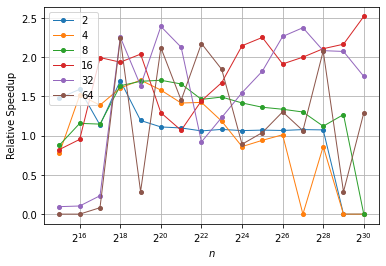

In [87]:
for p in cores:
    plt.plot(df_speedup['N'], df_speedup[str(p)], '-o', markersize=4, linewidth=1, label=p)
plt.legend()
plt.grid()
plt.xscale('log', basex=2)
plt.xlabel(r'$n$')
plt.ylabel('Relative Speedup')
# plt.show()
plt.savefig('beowulf_speedup.png', dpi=450)


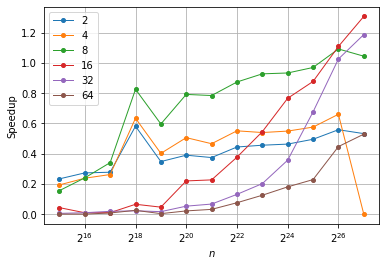

In [88]:
for p in cores:
    plt.plot(speedup_serial_df['N'], speedup_serial_df[str(p)], '-o', markersize=4, linewidth=1, label=p)
plt.legend()
plt.grid()
plt.xscale('log', basex=2)
plt.xlabel(r'$n$')
plt.ylabel('Speedup')
# plt.show()
plt.savefig('serial_speedup.png', dpi=450)